In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from collections import defaultdict
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset


In [2]:
# file_path = "exps/exp_FCNN_1000/run_2025-01-14_19-02-49/benchmarks/benchmark_stats_MisAlign-True_Tilt_True.pt"

# file_path = "exps/exp_FCNN_1000/GOLDEN_run_2025-01-14_08-53-50/benchmarks/benchmark_stats_MisAlign-True_Tilt_False.pt"
# file_path = "exps/exp_LSTM_2000_mix/GOLDEN_run_2025-01-17_00-19-35/benchmarks/benchmark_stats_MisAlign-True_Tilt_True.pt"

file_path = "exps/exp_LSTM_2000_mix/GOLDEN_run_2025-01-17_00-19-35/benchmarks/benchmark_stats_quad_tilt_MisAlign-True_Tilt-True.pt"

In [3]:
benchmark_stats = torch.load(file_path)

/tmp/ipykernel_1922756/3805608313.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  benchmark_stats = torch.load(file_path)


In [4]:
noise_list = list(benchmark_stats.keys())
noise_list

[0.01, 0.02, 0.03, 0.04, 0.05, 'benchmark_info']

In [5]:
benchmark_stats['benchmark_info']

{'benchmark_type': 'quad_tilt',
 'noise_start': 0.01,
 'noise_stop': 0.05,
 'bins': 5,
 'noise_pallette': array([0.01, 0.02, 0.03, 0.04, 0.05]),
 'runs_per_noise': 50,
 'fodo_mapping': {0: 1, 1: 2, 2: 3, 3: 4, 4: 5, 5: 7},
 'cancel_tilt_error': False,
 'cancel_misalign_error': False}

In [6]:
all_values = [i for i in benchmark_stats[0.01].values()]
all_values = np.array(all_values).flatten()
all_values.mean() * 1e6

0.03404532596357983

In [7]:
all_values = [i for i in benchmark_stats[0.05].values()]
all_values = np.array(all_values).flatten()
all_values.mean() * 1e6

0.19977709203537952

In [15]:
def get_local_plt_markers(nb_binz):
    plt_markers = Line2D.markers.copy()
    plt_markers.pop('')
    plt_markers.pop(' ')
    plt_markers.pop('None')
    plt_markers.pop('none')
    local_plt_markers_list = [pm for pm in plt_markers.keys()]
    
    if nb_binz > len(plt_markers):
        nb_repeat = int(ceil(nb_binz / len(plt_markers)))
        local_plt_markers_list = local_plt_markers_list * nb_repeat
        local_plt_markers_list = local_plt_markers_list[:nb_binz]
    
    return local_plt_markers_list

benchmark_info = benchmark_stats['benchmark_info']



def plot_benchmark_stats(stats, benchmark_info):
    noise_range = (benchmark_info["noise_start"], benchmark_info["noise_stop"])
    bins = benchmark_info["bins"]
    noise_pallette = benchmark_info["noise_pallette"]
    runs_per_noise = benchmark_info["runs_per_noise"]
    fodo_mapping = benchmark_info["fodo_mapping"]
    cancel_tilt_error = benchmark_info["cancel_tilt_error"]
    cancel_misalign_error = benchmark_info["cancel_misalign_error"]

    mean_errors = defaultdict(dict)
    std_errors = defaultdict(dict)
    
    for noise_level in stats:
        try:
            float(noise_level)
        except:
            continue
        for fodo_ix in stats[noise_level]:
            mean_errors[noise_level][fodo_ix] = np.mean(stats[noise_level][fodo_ix])
            std_errors[noise_level][fodo_ix] = np.std(stats[noise_level][fodo_ix])

    # Plotting accuracy vs noise_level for each FODO index
    plt.figure(figsize=(12, 8))
    fodo_indices = set()
    for noise_level in stats:
        fodo_indices.update(stats[noise_level].keys())
    fodo_indices = sorted(list(fodo_indices)[: len(benchmark_info['fodo_mapping']) ])

    local_plt_markers = get_local_plt_markers(len(fodo_indices))
    for fodo_ix in fodo_indices:
        means = [mean_errors[noise][fodo_ix] for noise in noise_pallette]
        means = np.array(means)
        marker = local_plt_markers[fodo_ix]
        plt.plot(noise_pallette * 1e3, means * 1e6, '-' + marker, label=f'FODO-QE-ix {fodo_mapping[fodo_ix]}')

    
    plt.xlabel('Noise Level (milliradian)', fontsize=18)
    plt.ylabel(f'Mean Absolute Error (µm)\nAveraging over {runs_per_noise} simulation runs\n', fontsize=18)
    plt.title(f'Model Prediction Accuracy vs Quad Tilt Noise Level (noise_range: {(noise_range[0] * 1000, noise_range[1] * 1000)} mrad, bins: {bins})\nMisAlign error: {not cancel_misalign_error}\nTilt errors: {not cancel_tilt_error}', fontsize=18)
    plt.legend(fontsize=14)
    plt.grid(True)
    # plt.minorticks_on()
    plt.xticks(noise_pallette * 1e3, fontsize=14, rotation=-45)
    plt.yticks(fontsize=14)
    plt.rc('font', size=14)
    
    
    
    
    # Create inset axes
    ax_main = plt.gca()
    ax_inset = inset_axes(ax_main, width="30%", height="10%", loc='lower right', borderpad=2.5)

    # Extract MAE for noise_level=0.0
    noise_zero_key = 0.01  # Adjust if noise levels are stored as floats
    if noise_zero_key in mean_errors:
        mae_zero = [mean_errors[noise_zero_key].get(fodo_ix, 0) * 1e6 for fodo_ix in fodo_indices]
        fodo_labels = [f'{fodo_mapping[fodo_ix]}' for fodo_ix in fodo_indices]
        fodo_labels_int = [fodo_mapping[fodo_ix] for fodo_ix in fodo_indices]

        # Plotting the inset bar chart
        ax_inset.bar(fodo_labels, mae_zero, color='skyblue', edgecolor='black')

        bars = ax_inset.bar(fodo_labels, mae_zero, color='skyblue', edgecolor='black')

        # Add text labels on each bar
        for bar in bars:
            height = bar.get_height()
            ax_inset.text(
                bar.get_x() + bar.get_width() / 2.,  # X-coordinate: center of the bar
                height - 0.015,                              # Y-coordinate: top of the bar
                f'{height:.2f}',                     # Text: MAE value with 3 decimals
                ha='center',                         # Horizontal alignment
                va='baseline',                         # Vertical alignment
                fontsize=11,
                color='black'
            )
        
        # ax_inset.plot(fodo_labels_int, mae_zero, 's')
        # ax_inset.plot(np.array(fodo_labels_int), np.array(mae_zero), '-')
        ax_inset.set_title('MAE at Noise=0', fontsize=11)
        ax_inset.set_ylabel('MAE (µm)', fontsize=11)
        ax_inset.set_xlabel('FODO Index', fontsize=11)
        ax_inset.tick_params(axis='both', which='major', labelsize=11)
        # plt.yticks(mae_zero)
        # plt.xticks(fodo_labels_int)
        ax_inset.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    
    
    
    
    
    plt.savefig(f"plot_benchmark_stats", bbox_inches = 'tight', format='eps')
    plt.savefig("exps/exp_LSTM_2000_mix/GOLDEN_run_2025-01-17_00-19-35/benchmarks/plot_accuracy_benchmark_quad_tilt_with_MisAlign_and_Tilt_error_in_data_1.eps", bbox_inches = 'tight', format='eps')
    plt.show()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


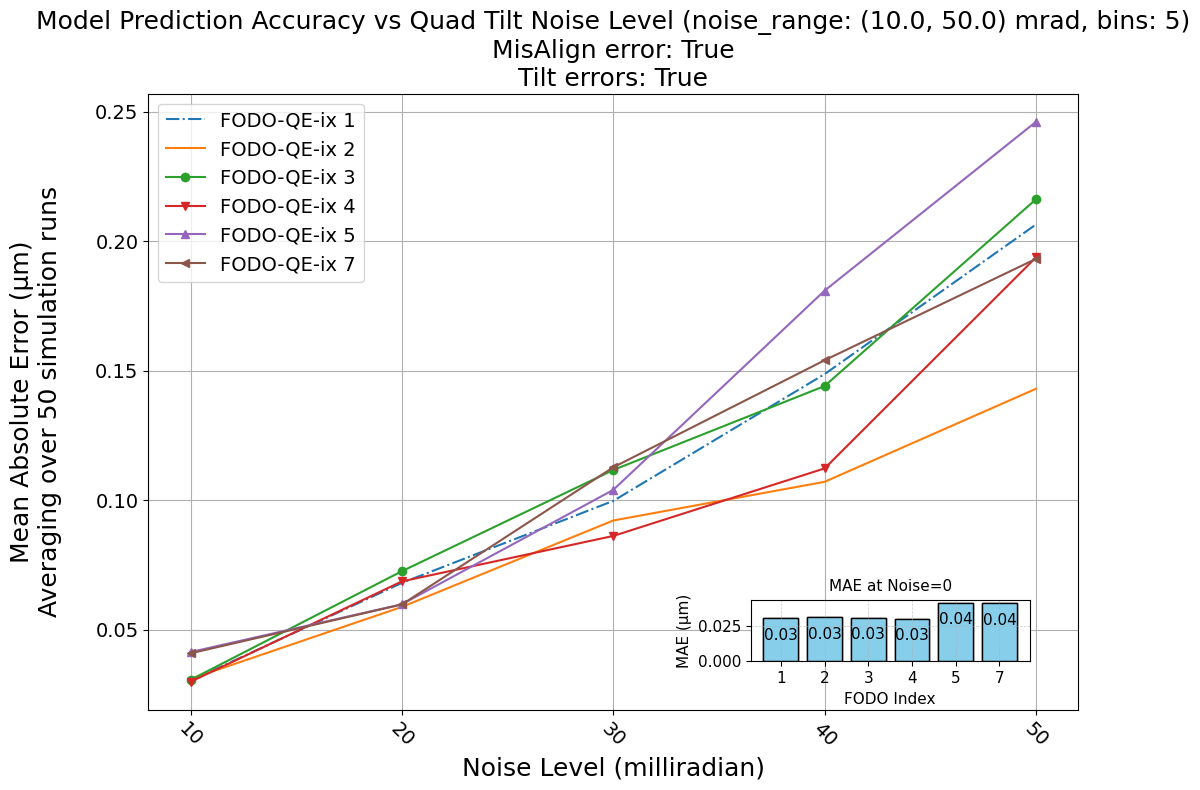

In [16]:
plot_benchmark_stats(benchmark_stats, benchmark_info)

In [37]:
benchmark_stats['benchmark_info'] = benchmark_info

In [38]:
# torch.save(benchmark_stats, "/home/aribra/jnps/thesis/lattice_error_net/exps/exp_FCNN_1000/run_2025-01-14_19-02-49/benchmarks/benchmark_stats_MisAlign-True_Tilt_True.pt")

In [235]:
benchmark_stats['benchmark_info']

{'noise_range': 0.0001,
 'bins': 11,
 'noise_pallette': array([0.e+00, 1.e-05, 2.e-05, 3.e-05, 4.e-05, 5.e-05, 6.e-05, 7.e-05,
        8.e-05, 9.e-05, 1.e-04]),
 'runs_per_noise': 50,
 'fodo_mapping': {0: 1, 1: 2, 2: 3, 3: 4, 4: 5, 5: 7},
 'cancel_tilt_error': False,
 'cancel_misalign_error': False}

In [ ]:
Fold 1 Unscaled Validation MAE: 0.0000052, 5.25
Fold 2 Unscaled Validation MAE: 0.0000056, 5.57
Fold 3 Unscaled Validation MAE: 0.0000057, 5.67
Fold 4 Unscaled Validation MAE: 0.0000052, 5.22
Fold 5 Unscaled Validation MAE: 0.0000052, 5.20


In [37]:
def plot_accuracy_per_fold(benchmark_results):
    """
    Plots the accuracy per fold for the cross-validation results.
    """
    # Extract fold numbers and their corresponding accuracies
    fold_numbers = list(benchmark_results['cross_validation']['results_val_mae_unscaled'].keys())
    accuracies = list(benchmark_results['cross_validation']['results_val_mae_unscaled'].values())
    accuracies = np.array(accuracies) * 1e6

    # Plot Accuracy per Fold
    plt.figure(figsize=(10, 6))
    plt.plot(fold_numbers, accuracies, marker='o', linestyle='-', color='b', label='MAE per Fold')

    # Customize the plot
    plt.xticks(fold_numbers, fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel('Fold Number', fontsize=18)
    plt.ylabel('MAE (µm)', fontsize=18)
    plt.title('Cross-Validation MAE per Fold', fontsize=20)
    plt.legend(fontsize=14)
    plt.grid(True)
    plt.minorticks_off()
    plt.ylim([accuracies.min() -0.5, accuracies.max()+0.5])

    plt.savefig("plot_accuracy_per_fold", bbox_inches='tight', format='eps')

    plt.show()





/tmp/ipykernel_566617/524721448.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  benchmark_results = torch.load("/home/aribra/jnps/thesis/lattice_error_net/exps/exp_LSTM_

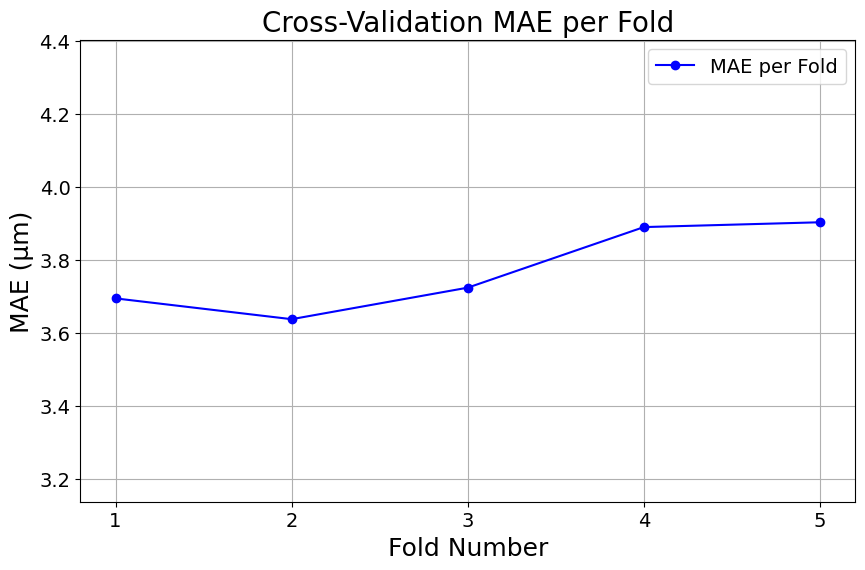

In [36]:
benchmark_results = torch.load("/home/aribra/jnps/thesis/lattice_error_net/exps/exp_LSTM_1000_mix/run_2025-01-17_11-59-18/benchmarks/benchmark_results_cross_validation.pt")

plot_accuracy_per_fold(benchmark_results)